Group members

EZAMAMTI RONALD AUSTINE

WANGOBI NICHOLAS KAKULU

WANGOLO BACHAWA


In [10]:
from datetime import datetime, timedelta
import bisect
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
# Task class to represent individual tasks
class Task:
    def __init__(self, title, task_type, deadline, duration):
        # Initialize task with title, type, deadline, and duration
        self.title = title                # Title of the task
        self.task_type = task_type        # Type of task: 'personal' or 'academic'
        self.deadline = deadline          # Deadline of the task (datetime object)
        self.duration = duration          # Duration of the task in hours

    def __repr__(self):
        # String representation of the task, used when displaying in lists
        return f"{self.title} ({self.task_type}) - Deadline: {self.deadline}, Duration: {self.duration}h"

# Scheduler class to manage tasks
class Scheduler:
    def __init__(self):
        # Initialize an empty list to store tasks
        self.tasks = []

    def add_task(self, task):
        """Add a new task to the scheduler and sort by deadline."""
        self.tasks.append(task)
        self.tasks.sort(key=lambda x: x.deadline)  # Sort tasks by deadline to ensure chronological order

    def delete_task(self, title):
        """Delete a task by title."""
        # Find and remove the task with the specified title
        task = self.search_task(title)
        if task:
            self.tasks.remove(task)
            return True
        return False

    def get_upcoming_tasks(self):
        """Return tasks that are upcoming within the next week."""
        # Find tasks with deadlines within the next 7 days
        now = datetime.now()
        upcoming = [task for task in self.tasks if now < task.deadline <= now + timedelta(days=7)]
        return upcoming

    def get_missed_tasks(self):
        """Return tasks that have been missed."""
        # Find tasks with deadlines that have already passed
        now = datetime.now()
        missed = [task for task in self.tasks if task.deadline < now]
        return missed

    def get_daily_task_load(self):
        """Calculate daily task load for each task type."""
        # Create a dictionary to store task loads for each day by type
        daily_load = {}
        for task in self.tasks:
            day = task.deadline.date()  # Use only the date part of the deadline
            if day not in daily_load:
                daily_load[day] = {"personal": 0, "academic": 0}
            # Accumulate duration for personal and academic tasks
            daily_load[day][task.task_type] += task.duration

        return daily_load

    def generate_stacked_bar_chart(self):
        """Generate a stacked bar chart to represent daily task loads."""
        # Get task loads by day and task type
        daily_load = self.get_daily_task_load()
        
        # Prepare data for the bar chart
        dates = sorted(daily_load.keys())
        personal_load = [daily_load[day]["personal"] for day in dates]
        academic_load = [daily_load[day]["academic"] for day in dates]
        
        # Create the bar chart
        fig, ax = plt.subplots()
        
        # Plot the stacked bars for personal and academic tasks
        ax.bar(dates, personal_load, label="Personal", color="skyblue")
        ax.bar(dates, academic_load, bottom=personal_load, label="Academic", color="lightgreen")
        
        # Set chart labels and title
        ax.set_xlabel("Date")
        ax.set_ylabel("Total Task Duration (Hours)")
        ax.set_title("Daily Task Load")
        ax.legend()

        # Format x-axis dates for readability
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        fig.autofmt_xdate()  # Rotate dates

        plt.show()

    def search_task(self, title):
        """Search for a task by title using binary search."""
        # Sort tasks by title and perform binary search to find the task by title
        self.tasks.sort(key=lambda x: x.title)
        titles = [task.title for task in self.tasks]
        index = bisect.bisect_left(titles, title)
        
        if index < len(titles) and titles[index] == title:
            return self.tasks[index]
        return None  # Task not found

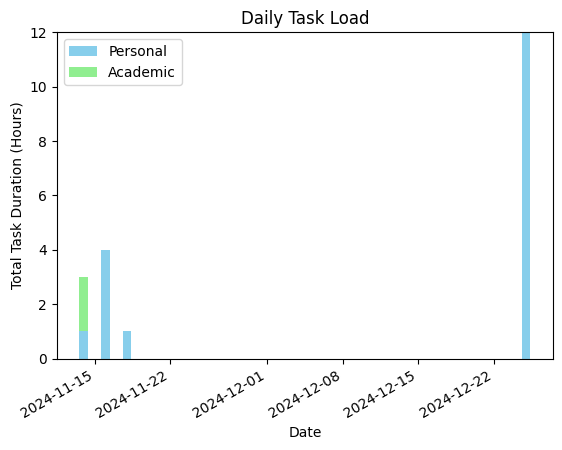

In [12]:
# GUI Application class
class SchedulerApp:
    def __init__(self, root):
        # Initialize GUI application
        self.scheduler = Scheduler()
        self.root = root
        self.root.title("Personal Scheduling Assistant")

        # Input fields for task details
        # Create entry and label for task title
        self.title_entry = tk.Entry(root, width=30)
        self.title_entry.grid(row=0, column=1, pady=(10, 0))
        tk.Label(root, text="Task Title:").grid(row=0, column=0, pady=(10, 0))

        # Create entry and label for task type
        self.type_entry = tk.Entry(root, width=30)
        self.type_entry.grid(row=1, column=1, pady=5)
        tk.Label(root, text="Task Type (personal/academic):").grid(row=1, column=0, pady=5)

        # Create entry and label for task deadline
        self.deadline_entry = tk.Entry(root, width=30)
        self.deadline_entry.grid(row=2, column=1, pady=5)
        tk.Label(root, text="Deadline (YYYY-MM-DD HH:MM):").grid(row=2, column=0, pady=5)

        # Create entry and label for task duration
        self.duration_entry = tk.Entry(root, width=30)
        self.duration_entry.grid(row=3, column=1, pady=5)
        tk.Label(root, text="Duration (hours):").grid(row=3, column=0, pady=5)

        # Buttons for adding and viewing tasks
        tk.Button(root, text="Add Task", command=self.add_task).grid(row=4, column=0, columnspan=2, pady=10)
        tk.Button(root, text="View Upcoming Tasks", command=self.view_tasks).grid(row=5, column=0, columnspan=2, pady=5)
        tk.Button(root, text="View Missed Tasks", command=self.view_missed_tasks).grid(row=6, column=0, columnspan=2, pady=5)
        tk.Button(root, text="Delete Task", command=self.delete_task).grid(row=7, column=0, columnspan=2, pady=5)
        tk.Button(root, text="Show Task Load Chart", command=self.show_stacked_bar_chart).grid(row=8, column=0, columnspan=2, pady=10)

        # Schedule a check for task notifications every minute
        self.check_notifications()

    def add_task(self):
        """Add a task to the scheduler from user input."""
        try:
            # Retrieve user input and create a Task object
            title = self.title_entry.get()
            task_type = self.type_entry.get().lower()
            deadline = datetime.strptime(self.deadline_entry.get(), "%Y-%m-%d %H:%M")
            duration = float(self.duration_entry.get())

            # Add task to scheduler and confirm with a message box
            task = Task(title, task_type, deadline, duration)
            self.scheduler.add_task(task)
            messagebox.showinfo("Success", "Task added successfully!")
            self.clear_entries()  # Clear input fields after adding
        except Exception as e:
            messagebox.showerror("Error", str(e))  # Display error message if input is invalid

    def view_tasks(self):
        """Display upcoming tasks in a message box."""
        # Get upcoming tasks and show in message box
        tasks = self.scheduler.get_upcoming_tasks()
        task_list = "\n".join(str(task) for task in tasks) if tasks else "No upcoming tasks."
        messagebox.showinfo("Upcoming Tasks", task_list)

    def view_missed_tasks(self):
        """Display missed tasks in a message box."""
        # Get missed tasks and show in message box
        tasks = self.scheduler.get_missed_tasks()
        if tasks:
            task_list = "\n".join(str(task) for task in tasks)
            messagebox.showinfo("Missed Tasks", task_list)
        else:
            messagebox.showinfo("Missed Tasks", "No missed tasks.")

    def delete_task(self):
        """Delete a task by title."""
        # Get task title from user input and delete the task
        title = self.title_entry.get()
        if self.scheduler.delete_task(title):
            messagebox.showinfo("Success", f"Task '{title}' deleted.")
            self.clear_entries()
        else:
            messagebox.showerror("Error", f"Task '{title}' not found.")

    def show_stacked_bar_chart(self):
        """Show stacked bar chart for daily task load."""
        # Generate and display stacked bar chart for daily task load
        self.scheduler.generate_stacked_bar_chart()

    def check_notifications(self):
        """Notify the user if a task's deadline is reached."""
        # Check each task for missed deadlines and show a warning if due
        now = datetime.now()
        for task in self.scheduler.tasks:
            if task.deadline <= now:
                messagebox.showwarning("Task Due", f"The task '{task.title}' is due now or past due!")
        
        # Schedule the next check in 60 seconds
        self.root.after(60000, self.check_notifications)

    def clear_entries(self):
        """Clear input fields after adding or deleting a task."""
        # Reset input fields to empty strings
        self.title_entry.delete(0, tk.END)
        self.type_entry.delete(0, tk.END)
        self.deadline_entry.delete(0, tk.END)
        self.duration_entry.delete(0, tk.END)

# Main function to run the application
if __name__ == "__main__":
    # Initialize and run the Tkinter application
    root = tk.Tk()
    app = SchedulerApp(root)
    root.mainloop()